In [5]:
import pandas as pd
coralDiseases = pd.read_csv('HICORDIS_Disease_Prevalences.csv')

In [6]:
import datetime
coralDiseases['Year'] = pd.DatetimeIndex(coralDiseases['Date']).year # make vector of survey year
coralDiseases["Outbreak"] = ""

In [7]:
import numpy as np
import heapq
cDiseases = coralDiseases.copy(deep=True)
timeSpan = range(2004,2016) # years 2004-2015
Diseases = ['Growth_anomalies_Prevalence', 'Tissue_Loss_Prevalence', 'White_Syndrome_Prevalence']

for condition in Diseases:
    maxPrevVector = [] # make vector with zero as the first element
    for year in timeSpan:
        subByYear = coralDiseases[coralDiseases.Year == year]
        maxPrev = max(subByYear[condition])
        maxPrevVector.extend([maxPrev])
    meanPrev = np.mean([maxPrevVector])
    sdPrev = np.std(maxPrevVector)
    threshold = meanPrev + sdPrev
    while max(maxPrevVector) > threshold:
        for i in maxPrevVector:
            if i > threshold:
                index = maxPrevVector.index(i)
                year = timeSpan[index]
                subByYear = cDiseases[cDiseases.Year == year]
                subByYearUnique = np.unique(subByYear[condition])
                secondHighestValue = heapq.nlargest(2, subByYearUnique)
                if len(secondHighestValue) == 1:
                    cDiseases[condition] = cDiseases[condition].replace([i], secondHighestValue[0])
                    newMaxPrev = max(cDiseases[condition])
                    maxPrevVector[index] = newMaxPrev
                else:
                    cDiseases[condition] = cDiseases[condition].replace([i], secondHighestValue[1])
                    newMaxPrev = max(cDiseases[condition])
                    maxPrevVector[index] = newMaxPrev
        meanPrev = np.mean([maxPrevVector])
        sdPrev = np.std(maxPrevVector)
        threshold = meanPrev + sdPrev
    print "%s = %s threshold" %(threshold, condition)
    coralDiseases['Outbreak'] = np.where( ( (coralDiseases[condition] >= threshold)  ), 1, 0)    

16.3438578066 = Growth_anomalies_Prevalence threshold
34.7898484814 = Tissue_Loss_Prevalence threshold
0.44538755766 = White_Syndrome_Prevalence threshold


In [202]:
# mean & 95% thresholds
import pylab, cProfile, scipy.stats as ss
Diseases = ['Growth_anomalies_Prevalence', 'Tissue_Loss_Prevalence', 'White_Syndrome_Prevalence']

def conf_int_scipy(x, ci=0.95):
  low_per = 100*(1-ci)/2.
  high_per = 100*ci + low_per
  mn = x.mean()
  cis = ss.scoreatpercentile(x, [low_per, high_per])
  return mn, cis

condition = 'White_Syndrome_Prevalence'
#for condition in Diseases:
conf_int_scipy(coralDiseases[condition])


(0.0015527648247328711, array([ 0.        ,  0.00842856]))

In [10]:
# put pdfs in single canvas
from os import listdir
plotList = listdir("scatterplots")
import matplotlib.pyplot as plt
import pylab
%matplotlib inline 

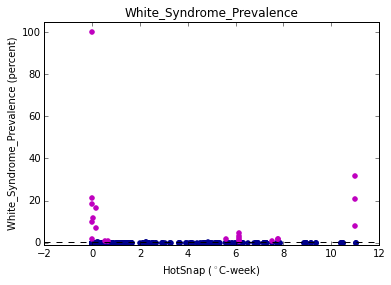

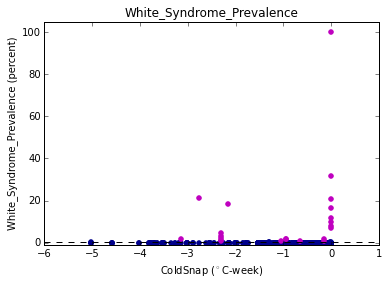

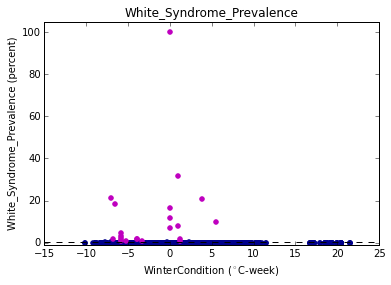

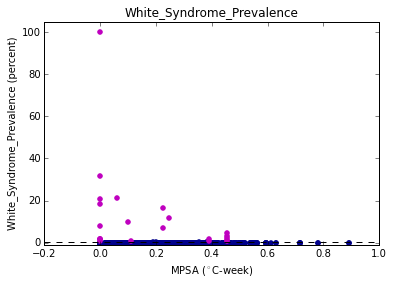

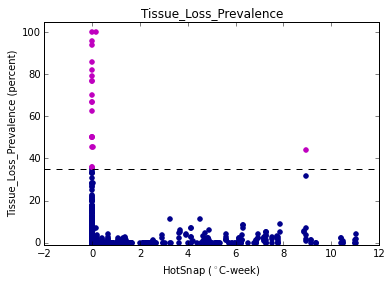

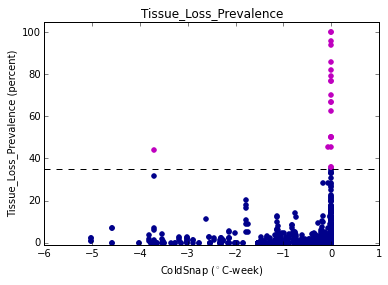

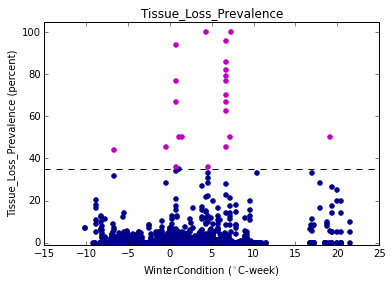

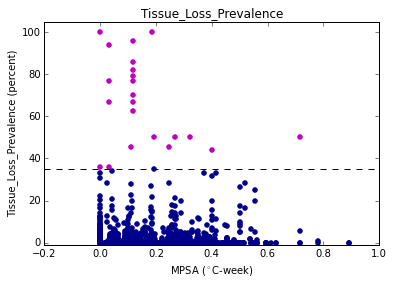

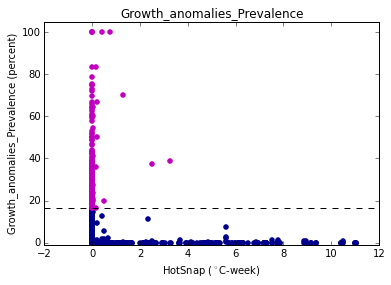

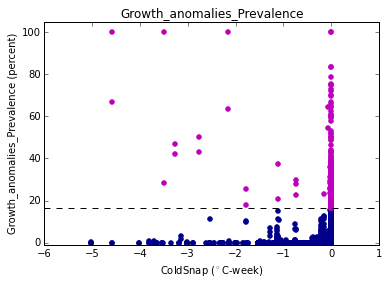

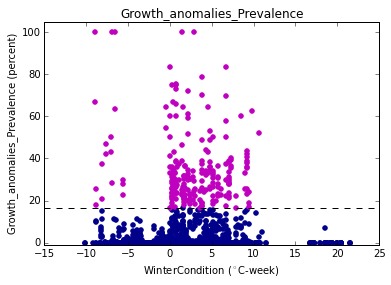

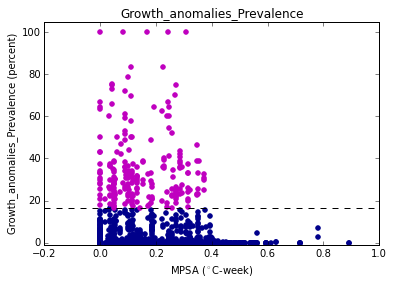

In [102]:
# create scatterplots of sst metrics vs. coral disease prevalences

SSTmetrics = ['HotSnap', 'ColdSnap', 'WinterCondition', 'MPSA']
Diseases = ['White_Syndrome_Prevalence', 'Tissue_Loss_Prevalence', 'Growth_anomalies_Prevalence']

for coralDisease in Diseases: # for all diseases
    if coralDisease == 'Tissue_Loss_Prevalence':
        threshold = 34.7898484814
    elif coralDisease == 'Growth_anomalies_Prevalence':
        threshold = 16.3438578066
    else:
        threshold = 0.44538755766
    for sst in SSTmetrics: # for all sst metrics
        belowThreshold = coralDiseases[coralDiseases[coralDisease] < threshold]
        aboveThreshold = coralDiseases[coralDiseases[coralDisease] >= threshold]
        plt.figure()
        plt.scatter(belowThreshold[sst], belowThreshold[coralDisease], color='darkblue')
        plt.scatter(aboveThreshold[sst], aboveThreshold[coralDisease], color='m')
        plt.axhline(y = threshold, linewidth=1, linestyle='dashed', color = 'k')
        pylab.title(coralDisease) # add plot title
        pylab.xlabel('%s ($^\circ$C-week)' %sst) # add x-axis label
        pylab.ylabel('%s (percent)' %coralDisease) # add y-axis label
        pylab.ylim([-1,105])
        plt.savefig('scatterplots/%s_%s.pdf' %(coralDisease, sst)) # save as png, name according to sst metric & disease type

In [286]:
plt.scatter(coralDiseases[sst], coralDiseases[coralDisease], c='r') # create scatterplot(x,y)
plt.scatter(coralDiseases[sst], coralDiseases['Growth_anomalies_Prevalence], c='b') # create scatterplot(x,y)
pylab.title(coralDisease) # add plot title
pylab.xlabel('%s ($^\circ$C-week)' %sst) # add x-axis label
pylab.ylabel('%s (percent)' %coralDisease) # add y-axis label
plt.axhline(y=threshold, linewidth=1, linestyle='dashed', color = 'k')

x = linspace(0,10)
y1 = randn(50)
y2 = randn(50)+10

scatter(x, y1, color='red')
scatter(x, y2, color='blue')

TypeError: invalid type comparison

In [263]:
?plt.axhline

In [6]:
list(coralDiseases.columns.values) # find column names

['Date',
 'Latitude',
 'Longitude',
 'Region',
 'Island',
 'Site',
 'Transect_Number',
 'Colony_Density',
 'Montipora_Density',
 'Porites_Density',
 'Tissue_Loss_Prevalence',
 'Growth_anomalies_Prevalence',
 'White_Syndrome_Prevalence',
 'sst_lat',
 'sst_lon',
 'DHW_from_HSge1',
 'DHW_from_HSgt0',
 'MPSA',
 'HotSnap',
 'ColdSnap',
 'WinterCondition',
 'Year']

In [25]:
for i in maxPrevVector:
    print i

0.0112820512821
11.1111111111
33.3333333333
0.00571428571429
2.94117647059
0.0
50.0
96.0
50.0
50.0
44.0
1.28205128205


In [19]:
subByYear = coralDiseases[coralDiseases.Year == 2010]
print max(subByYear['Tissue_Loss_Prevalence'])
secondHighestValue = heapq.nlargest(2, subByYear['Tissue_Loss_Prevalence'])
print secondHighestValue[1]
subByValue = subByYear['Tissue_Loss_Prevalence'].replace([i], secondHighestValue[1])
print max(subByValue)


100.0
50.0
100.0


In [6]:

[0.0112820512820513, 11.1111111111111, 1.4634146341463401, 0.0057142857142857099, 2.9411764705882399, 0.0, 12.5, 20.0, 14.285714285714299, 14.285714285714299, 11.309523809523801, 1.2820512820512799]
7.43297518465
6.86307669058
14.2960518752

100.0


In [2]:
# Decision Tree Classifier
from sklearn import datasets
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
 
# load the iris datasets
dataset = datasets.load_iris()


In [3]:
# fit a CART model to the data
model = DecisionTreeClassifier()
model.fit(dataset.data, dataset.target)
print(model)


DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=1, min_samples_split=2,
            random_state=None, splitter='best')


In [32]:
class(coralDiseases[1])

SyntaxError: invalid syntax (<ipython-input-32-f38b5cefb3c8>, line 1)

In [4]:
# make predictions
expected = dataset.target
predicted = model.predict(dataset.data)


In [5]:
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       1.00      1.00      1.00        50
          2       1.00      1.00      1.00        50

avg / total       1.00      1.00      1.00       150

[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


In [6]:
# Decision Tree Classifier
from sklearn import datasets
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
# load the iris datasets
dataset = datasets.load_iris()
# fit a CART model to the data
model = DecisionTreeClassifier()
model.fit(dataset.data, dataset.target)
print(model)
# make predictions
expected = dataset.target
predicted = model.predict(dataset.data)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=1, min_samples_split=2,
            random_state=None, splitter='best')
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       1.00      1.00      1.00        50
          2       1.00      1.00      1.00        50

avg / total       1.00      1.00      1.00       150

[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


In [ ]:
time = getColumn("filename",0)
volt = getColumn("filaname",1)

plt.figure("Time/Volt")
plt.xlabel("Time(ms)")
plt.ylabel("Volt(mV)")
plt.plot(time,volt)

NameError: name 'matplotlib' is not defined